In [63]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.utils as vutils
import torch.nn.functional as F

from torchvision import transforms
from torchvision.utils import save_image

from collections import OrderedDict 

import matplotlib.pyplot as plt

import random

import numpy as np

In [2]:
# Put everything on a GPU if that is availalbe
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently using [{device}] as the main device")

Currently using [cuda] as the main device


### A seperate attempt with CNNs on GANs

Following lessons on https://iq.opengenus.org/deep-convolutional-gans-pytorch/

In [4]:
# Image transformation class and image extraction
transform = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.3, p=0.3),
    transforms.RandomRotation(degrees=(0, 80)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

mnist = torchvision.datasets.MNIST(root="./data",
                                   train=True,
                                   transform=transform,
                                   download=True)

mnist_clean = torchvision.datasets.MNIST(root="./data",
                                   train=True,
                                   transform=transform_clean,
                                   download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size,
                                          shuffle=True)

data_loader_clean = torch.utils.data.DataLoader(dataset=mnist_clean,
                                                batch_size=batch_size,
                                                shuffle=True)

In [5]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv1_bn = nn.BatchNorm2d(num_features=32)
        self.dropout1 = nn.Dropout(p=0.25)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(num_features=64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.dropout2 = nn.Dropout(p=0.4)
        
        self.fc1 = nn.Linear(in_features=7*7*64, out_features=512, bias=True)
        self.out = nn.Linear(in_features=512, out_features=1)
        self.activation = nn.Sigmoid()
        
    def forward(self, t):
        # (1) input layer
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = self.conv1_bn(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        t = self.dropout1(t)
        
        # (3) hiddne conv layer
        t = self.conv2(t)
        t = self.conv2_bn(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        t = self.dropout2(t)
        
        # (4) hidden linear layer
        t = t.reshape(-1, 7*7*64)
        t = self.fc1(t)
        t = F.relu(t)
        
        # (5) output layer
        t = self.out(t)
        t = self.activation(t)
        #t = F.sigmoid(t)
        
        return t

In [6]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        # I'm sure there is a mathematical explanation to how upsampling of correct dimensions happen
        # But I don't know it and had to eyeball it...good luck changing or debugging this future me.
        self.deconv1 = nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0)
        self.deconv1_bn = nn.BatchNorm2d(num_features=512)
        
        self.deconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=0)
        self.deconv2_bn = nn.BatchNorm2d(num_features=256)
        
        self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, padding=0)
        self.deconv3_bn = nn.BatchNorm2d(num_features=128)
        
        self.deconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=6, stride=1, padding=0)
        self.activation = nn.Tanh()

    def forward(self, input):
        
        # (1) Hidden ConvTranspose2D layer
        t = self.deconv1(input)
        t = self.deconv1_bn(t)
        t = F.relu(t)
        
        # (2) Hidden ConvTranspose2D layer
        t = self.deconv2(t)
        t = self.deconv2_bn(t)
        t = F.relu(t)
        
        # (3) Hidden ConvTranspose2D layer
        t = self.deconv3(t)
        t = self.deconv3_bn(t)
        t = F.relu(t)
        
        # (4) Upscale and ouput layer
        t = self.deconv4(t)
        # t = F.tanh(t)
        t = self.activation(t)
        
        return t

In [7]:
def weights_init(m):
    """
    Reference: https://debuggercafe.com/implementing-deep-convolutional-gan-with-pytorch/
    
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# Create Networks
G = Generator()
D = Discriminator()

# Move them to devices
D = D.to(device)
G = G.to(device)

# Chose the criterion - which is Binary Classifier and create optimizers
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# initialize generator and discriminator weights
G.apply(weights_init)
D.apply(weights_init)

print(G)
print(D)

Generator(
  (deconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2))
  (deconv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2))
  (deconv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 1, kernel_size=(6, 6), stride=(1, 1))
  (activation): Tanh()
)
Discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

real data 1.0 <- [0.5085238814353943] -> 0.0 fake data


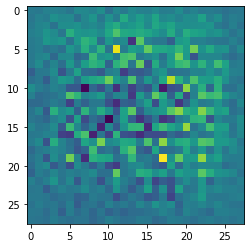

In [158]:
# Verify that currntly only random noise is being generated in correct proportions
G.eval()
D.eval()

with torch.no_grad():
    _z = torch.randn((1, 100)).view(-1, 100, 1, 1)
    some_img = G(_z.to(device))
    print(f"real data 1.0 <- [{D(some_img)[0][0]}] -> 0.0 fake data")

    # See how well the generator works now
    plt.imshow(some_img.detach().clone().cpu().reshape(28, 28))

In [40]:
# Create a training structure
total_steps = len(data_loader_clean)

# Update some hyperparameters depending on our preference in how to use them
num_epochs = 10
batch_size = 64

# Put the networks into the training mode
D.train()
G.train()

# Initiate the steps through epochs
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader_clean):
        
        mini_batch = images.size()[0]
        
        # Create labels with which we identify the data
        real_labels = torch.ones(mini_batch, 1).to(device)
        fake_labels = torch.zeros(mini_batch, 1).to(device)
        
        # !!!!!!!!!!!!!!!!!!!!!!! TRAIN THE DISCRIMINATOR !!!!!!!!!!!!!!!!!!!!!!!
        D.zero_grad()
        images = images.to(device)
        outputs = D(images.to(device))
        
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Computer the Binary Cross Entropy with fake images, that are generated by the Generator from random noise
        z = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Calculate the value for backpropogation and optimize
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        
        # !!!!!!!!!!!!!!!!!!!!!!! TRAIN THE GENERATOR !!!!!!!!!!!!!!!!!!!!!!!
        G.zero_grad()
        z = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        g_loss = criterion(outputs, real_labels)
        
        # Backpropogation and optimization
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 500 == 0:
            log = (
                f"Epoch: [{epoch+1}/{num_epochs}], "             \
                f"Step: [{i+1}/{total_steps}], "                 \
                f"D_loss: {round(d_loss.item(), 3)}, "           \
                f"G_loss: {round(g_loss.item(), 3)}, "           \
                f"D(x): {round(real_score.mean().item(), 3)}, "  \
                f"D(G(z)): {round(fake_score.mean().item(), 3)}"
            )
            print(log)
    print("==================================================================================================")

Epoch: [1/10], Step: [500/1875], D_loss: 0.881, G_loss: 1.377, D(x): 0.714, D(G(z)): 0.287
Epoch: [1/10], Step: [1000/1875], D_loss: 1.123, G_loss: 1.232, D(x): 0.68, D(G(z)): 0.389
Epoch: [1/10], Step: [1500/1875], D_loss: 1.126, G_loss: 1.334, D(x): 0.648, D(G(z)): 0.374
Epoch: [2/10], Step: [500/1875], D_loss: 1.242, G_loss: 1.424, D(x): 0.629, D(G(z)): 0.359
Epoch: [2/10], Step: [1000/1875], D_loss: 0.778, G_loss: 1.372, D(x): 0.746, D(G(z)): 0.292
Epoch: [2/10], Step: [1500/1875], D_loss: 0.701, G_loss: 2.422, D(x): 0.683, D(G(z)): 0.197
Epoch: [3/10], Step: [500/1875], D_loss: 0.837, G_loss: 2.093, D(x): 0.656, D(G(z)): 0.242
Epoch: [3/10], Step: [1000/1875], D_loss: 0.731, G_loss: 1.368, D(x): 0.74, D(G(z)): 0.257
Epoch: [3/10], Step: [1500/1875], D_loss: 1.026, G_loss: 1.198, D(x): 0.686, D(G(z)): 0.347
Epoch: [4/10], Step: [500/1875], D_loss: 0.764, G_loss: 1.612, D(x): 0.74, D(G(z)): 0.263
Epoch: [4/10], Step: [1000/1875], D_loss: 0.921, G_loss: 2.011, D(x): 0.57, D(G(z)): 0.

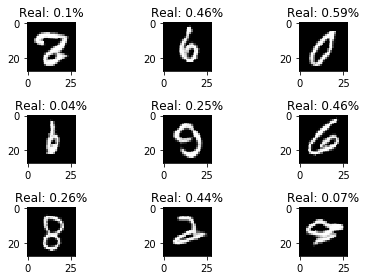

In [100]:
G.eval()
D.eval()

rows = 3
cols = 3
axes=[]
fig=plt.figure()

with torch.no_grad():
    for a in range(rows*cols):
        _z = torch.randn((1, 100)).view(-1, 100, 1, 1)
        some_img = G(_z.to(device))
        axes.append(fig.add_subplot(rows, cols, a+1))
        subplot_title=(f"Real: {str(round(D(some_img).item(), 2))}%")
        axes[-1].set_title(subplot_title)  
        plt.imshow(some_img.detach().clone().cpu().reshape(28, 28), cmap=plt.cm.gray)
    fig.tight_layout()    
    plt.show()

In [92]:
x_val.size()

torch.Size([1, 28, 28])

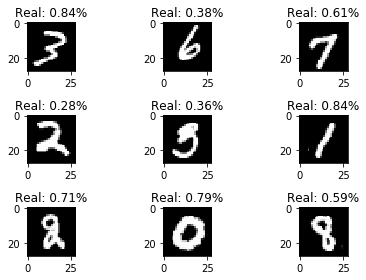

In [103]:
rows = 3
cols = 3
axes=[]
fig=plt.figure()

for a in range(rows*cols):
    idx=random.randint(0, random.randint(0, len(mnist_clean)))
    x_val, y_label = mnist_clean[idx]
    x_val = x_val.view(-1, 1, 28, 28).to(device)
    axes.append(fig.add_subplot(rows, cols, a+1))
    subplot_title=(f"Real: {str(round(D(x_val).item(), 2))}%")
    axes[-1].set_title(subplot_title)
    plt.imshow(x_val.detach().clone().cpu().squeeze().numpy(), cmap=plt.cm.gray)
fig.tight_layout()  
plt.show()

tensor([[0.0683]], device='cuda:0')


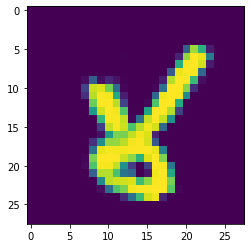

In [67]:
# And verify that our Discriminator has no clue what it is predicting
G.eval()
D.eval()

with torch.no_grad():
    _z = torch.randn((1, 100)).view(-1, 100, 1, 1)
    some_img = G(_z.to(device))
    print(D(some_img))

    # See how well the generator works now
    plt.imshow(some_img.detach().clone().cpu().reshape(28, 28))

In [73]:
round(D(some_img).item(), 2)

0.41

In [101]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G_conv.ckpt')
torch.save(D.state_dict(), 'D_conv.ckpt')

In [489]:
# Hyper Parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 5
batch_size = 32

encoder_size = 64
hidden_size_min = 256
hidden_size_mid = 256

In [490]:
# Image transformation class and image extraction
transform = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.3, p=0.3),
    transforms.RandomRotation(degrees=(0, 80)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

mnist = torchvision.datasets.MNIST(root="./data",
                                   train=True,
                                   transform=transform,
                                   download=True)

mnist_clean = torchvision.datasets.MNIST(root="./data",
                                   train=True,
                                   transform=transform_clean,
                                   download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size,
                                          shuffle=True)

In [491]:
# Prepare the Generator and Discriminator
D = nn.Sequential(
    OrderedDict([
                 ("fc1",   nn.Linear(in_features=image_size, 
                                     out_features=hidden_size,
                                     bias=True)),
                 ("relu1", nn.LeakyReLU(negative_slope=0.2)),
                 ("fc2",   nn.Linear(in_features=hidden_size, 
                                     out_features=hidden_size,
                                     bias=True)),
                 ("relu2", nn.LeakyReLU(negative_slope=0.2)),
                 ("fc3",   nn.Linear(in_features=hidden_size,
                                     out_features=1,
                                     bias=True)),
                 ("activ", nn.Sigmoid())
    ])
)

G = nn.Sequential(
    OrderedDict([
                 ("fc1",   nn.Linear(in_features=latent_size,
                                     out_features=hidden_size,
                                     bias=True)),
                 ("relu1", nn.ReLU()),
                 ("fc2",   nn.Linear(in_features=hidden_size,
                                     out_features=hidden_size,
                                     bias=True)),
                 ("relu2", nn.ReLU()),
                 ("fc3",   nn.Linear(in_features=hidden_size,
                                     out_features=image_size,
                                     bias=True)),
                 ("activ", nn.Tanh())
    ])
)

In [492]:
# Prepare Encoder
E = nn.Sequential(
    OrderedDict([
        ("InLayer", nn.Linear(in_features=image_size, 
                              out_features=encoder_size,
                              bias=True)),
        ("relu1", nn.ReLU()),
        ("LatentSpace", nn.Linear(in_features=encoder_size, 
                                  out_features=hidden_size_min,
                                  bias=True)),
        ("relu2", nn.ReLU()),
        ("fc1", nn.Linear(in_features=hidden_size_min, 
                          out_features=hidden_size_mid,
                          bias=True)),
        ("relu3", nn.ReLU()),
        ("OutLayer", nn.Linear(in_features=hidden_size_mid, 
                               out_features=image_size,
                               bias=True)),
        ("activation", nn.Tanh())
    ])
)

In [493]:
print(D)
print(G)
print(E)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (activ): Sigmoid()
)
Sequential(
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=256, out_features=784, bias=True)
  (activ): Tanh()
)
Sequential(
  (InLayer): Linear(in_features=784, out_features=64, bias=True)
  (relu1): ReLU()
  (LatentSpace): Linear(in_features=64, out_features=256, bias=True)
  (relu2): ReLU()
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (relu3): ReLU()
  (OutLayer): Linear(in_features=256, out_features=784, bias=True)
  (activation): Tanh()
)


In [494]:
# Put the networks to a functioning device
D = D.to(device)
G = G.to(device)
E = E.to(device)

In [501]:
# First we prepare the encoder decoder working parameters
e_criterion = nn.MSELoss()
e_optimizer = torch.optim.Adam(E.parameters(), lr=0.0002)

In [496]:
# Prepare the training loop and execute it
for epoch in range(50):
    loss = 0
    for i, (images, _) in enumerate(data_loader):
        images =images.reshape(batch_size, -1).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        e_optimizer.zero_grad()
        
        # compute reconstructions
        outputs = E(images)
        
        # compute training reconstruction loss
        train_loss = e_criterion(outputs, images)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        e_optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(data_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, 30, loss))

epoch : 1/30, loss = 0.926367
epoch : 2/30, loss = 0.919902
epoch : 3/30, loss = 0.912856
epoch : 4/30, loss = 0.903646
epoch : 5/30, loss = 0.890527
epoch : 6/30, loss = 0.870679
epoch : 7/30, loss = 0.840043
epoch : 8/30, loss = 0.792311
epoch : 9/30, loss = 0.721224
epoch : 10/30, loss = 0.625411
epoch : 11/30, loss = 0.514716
epoch : 12/30, loss = 0.413122
epoch : 13/30, loss = 0.343283
epoch : 14/30, loss = 0.305422
epoch : 15/30, loss = 0.286317
epoch : 16/30, loss = 0.275859
epoch : 17/30, loss = 0.270720
epoch : 18/30, loss = 0.267402
epoch : 19/30, loss = 0.265194
epoch : 20/30, loss = 0.263727
epoch : 21/30, loss = 0.262747
epoch : 22/30, loss = 0.262615
epoch : 23/30, loss = 0.261838
epoch : 24/30, loss = 0.260792
epoch : 25/30, loss = 0.258757
epoch : 26/30, loss = 0.257009
epoch : 27/30, loss = 0.256411
epoch : 28/30, loss = 0.255978
epoch : 29/30, loss = 0.256076
epoch : 30/30, loss = 0.255579
epoch : 31/30, loss = 0.255428
epoch : 32/30, loss = 0.255033
epoch : 33/30, lo

In [451]:
torch.save(E.state_dict(), 'E.ckpt')

In [256]:
# Chose the criterion - which is Binary Classifier and create optimizers
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [257]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

Representing number 4


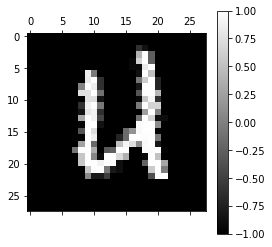

In [333]:
# An alternative way of showing the said data
ix=64
x, y = mnist[ix]
plt.matshow(x.squeeze().numpy(), cmap=plt.cm.gray)
print(f"Representing number {y}")
plt.colorbar()

Representing number 5


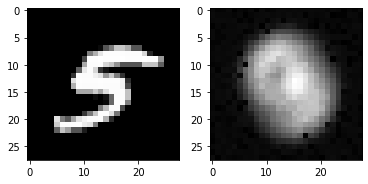

In [500]:
idx=random.randint(0, random.randint(0, len(mnist_clean)))
x_val, y_label = mnist_clean[idx]

print(f"Representing number {y_label}")
f, axarr = plt.subplots(1,2)

new_x = E(x_val.to(device).reshape(1, -1).to(device))
new_x = new_x.cpu().detach().reshape(-1, 28)

# Original Value
axarr[0].imshow(x_val.squeeze().numpy(), cmap=plt.cm.gray)
# Generated through Encoding-Decoding
axarr[1].imshow(new_x, cmap=plt.cm.gray)

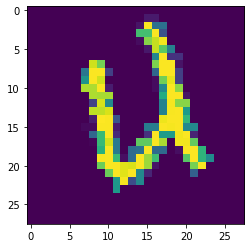

In [261]:
plt.imshow(x.squeeze().numpy())

The image is related to the number: 4


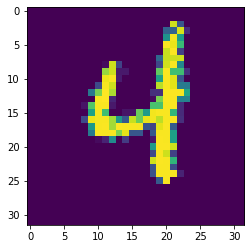

In [226]:
# # Let's make this data make more sense
# instance_record = next(iter(data_loader))
# plt.imshow(instance_record[0][0][0])      # Instance where matrices are stored, Entry in the batch, Entry in the instance
# print(f"The image is related to the number: {instance_record[1][0]}")  # Instance where values are located, Entry in the instance

In [217]:
# Create a training structure
total_steps = len(data_loader)
collect_x_gen = []
for epoch in range(50):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create labels with which we identify the data
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # !!!!!!!!!!!!!!!!!!!!!!! TRAIN THE DISCRIMINATOR !!!!!!!!!!!!!!!!!!!!!!!
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Computer the Binary Cross Entropy with fake images, that are generated by the Generator from random noise
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Calculate the value for backpropogation and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        
        # !!!!!!!!!!!!!!!!!!!!!!! TRAIN THE GENERATOR !!!!!!!!!!!!!!!!!!!!!!!
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        g_loss = criterion(outputs, real_labels)
        
        # Backpropogation and optimization
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 500 == 0:
            log = (
                f"Epoch: [{epoch+1}/{num_epochs}], "             \
                f"Step: [{i+1}/{total_steps}], "                 \
                f"D_loss: {round(d_loss.item(), 3)}, "           \
                f"G_loss: {round(g_loss.item(), 3)}, "           \
                f"D(x): {round(real_score.mean().item(), 3)}, "  \
                f"D(G(z)): {round(fake_score.mean().item(), 3)}"
            )
            print(log)
    print("==================================================================================================")

Epoch: [1/5], Step: [500/1875], D_loss: 0.015, G_loss: 5.89, D(x): 0.997, D(G(z)): 0.012
Epoch: [1/5], Step: [1000/1875], D_loss: 0.086, G_loss: 4.801, D(x): 0.94, D(G(z)): 0.021
Epoch: [1/5], Step: [1500/1875], D_loss: 0.192, G_loss: 4.261, D(x): 0.941, D(G(z)): 0.115
Epoch: [2/5], Step: [500/1875], D_loss: 0.128, G_loss: 2.879, D(x): 0.968, D(G(z)): 0.087
Epoch: [2/5], Step: [1000/1875], D_loss: 0.136, G_loss: 2.609, D(x): 0.96, D(G(z)): 0.08
Epoch: [2/5], Step: [1500/1875], D_loss: 0.116, G_loss: 6.096, D(x): 0.948, D(G(z)): 0.005
Epoch: [3/5], Step: [500/1875], D_loss: 0.042, G_loss: 6.041, D(x): 0.983, D(G(z)): 0.017
Epoch: [3/5], Step: [1000/1875], D_loss: 0.41, G_loss: 2.99, D(x): 0.855, D(G(z)): 0.027
Epoch: [3/5], Step: [1500/1875], D_loss: 0.298, G_loss: 5.983, D(x): 0.874, D(G(z)): 0.02
Epoch: [4/5], Step: [500/1875], D_loss: 0.295, G_loss: 5.744, D(x): 0.919, D(G(z)): 0.025
Epoch: [4/5], Step: [1000/1875], D_loss: 0.097, G_loss: 5.469, D(x): 0.961, D(G(z)): 0.038
Epoch: [4/

Epoch: [23/5], Step: [1000/1875], D_loss: 0.783, G_loss: 2.234, D(x): 0.744, D(G(z)): 0.22
Epoch: [23/5], Step: [1500/1875], D_loss: 0.555, G_loss: 2.658, D(x): 0.75, D(G(z)): 0.087
Epoch: [24/5], Step: [500/1875], D_loss: 0.746, G_loss: 2.279, D(x): 0.641, D(G(z)): 0.101
Epoch: [24/5], Step: [1000/1875], D_loss: 0.846, G_loss: 2.763, D(x): 0.669, D(G(z)): 0.182
Epoch: [24/5], Step: [1500/1875], D_loss: 0.796, G_loss: 1.668, D(x): 0.637, D(G(z)): 0.159
Epoch: [25/5], Step: [500/1875], D_loss: 0.79, G_loss: 2.721, D(x): 0.692, D(G(z)): 0.165
Epoch: [25/5], Step: [1000/1875], D_loss: 0.755, G_loss: 1.871, D(x): 0.836, D(G(z)): 0.307
Epoch: [25/5], Step: [1500/1875], D_loss: 0.553, G_loss: 1.778, D(x): 0.833, D(G(z)): 0.252
Epoch: [26/5], Step: [500/1875], D_loss: 1.012, G_loss: 0.856, D(x): 0.664, D(G(z)): 0.244
Epoch: [26/5], Step: [1000/1875], D_loss: 0.596, G_loss: 1.99, D(x): 0.757, D(G(z)): 0.209
Epoch: [26/5], Step: [1500/1875], D_loss: 0.92, G_loss: 1.463, D(x): 0.811, D(G(z)): 0.

Epoch: [45/5], Step: [1000/1875], D_loss: 0.928, G_loss: 1.234, D(x): 0.655, D(G(z)): 0.306
Epoch: [45/5], Step: [1500/1875], D_loss: 1.059, G_loss: 1.895, D(x): 0.732, D(G(z)): 0.405
Epoch: [46/5], Step: [500/1875], D_loss: 1.063, G_loss: 1.137, D(x): 0.692, D(G(z)): 0.377
Epoch: [46/5], Step: [1000/1875], D_loss: 0.791, G_loss: 1.568, D(x): 0.669, D(G(z)): 0.227
Epoch: [46/5], Step: [1500/1875], D_loss: 1.18, G_loss: 1.705, D(x): 0.562, D(G(z)): 0.311
Epoch: [47/5], Step: [500/1875], D_loss: 0.86, G_loss: 1.935, D(x): 0.629, D(G(z)): 0.199
Epoch: [47/5], Step: [1000/1875], D_loss: 0.84, G_loss: 1.772, D(x): 0.677, D(G(z)): 0.237
Epoch: [47/5], Step: [1500/1875], D_loss: 0.726, G_loss: 1.697, D(x): 0.728, D(G(z)): 0.204
Epoch: [48/5], Step: [500/1875], D_loss: 0.731, G_loss: 1.711, D(x): 0.783, D(G(z)): 0.33
Epoch: [48/5], Step: [1000/1875], D_loss: 1.214, G_loss: 1.364, D(x): 0.628, D(G(z)): 0.393
Epoch: [48/5], Step: [1500/1875], D_loss: 0.772, G_loss: 1.637, D(x): 0.704, D(G(z)): 0

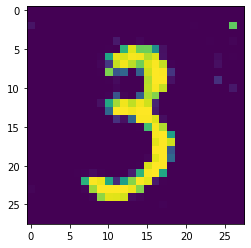

In [234]:
some_noise = torch.randn(1, latent_size).to(device)
x_gen = G(some_noise)
plt.imshow(x_gen.detach().clone().cpu().reshape(28, 28))

In [235]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')